# Tutorial: Information processing in recurrent neural networks and the role of category-orthogonal object features

___
By Clemens Bartnik & Amber Brands, June 2022, for the `Interpretability & Explainability in AI` course of the UvA AI Master. The code has been taken from the author's [Github](https://github.com/KietzmannLab/svrhm21_RNN_explain.git). 

## About this tutorial
In this tutorial we will explore information processing in a pretrained recurrent neural network (RNN) trained for object recognition and investigate the role of category-orthogonal object features on task solving and performance. More precisely, we will focus on the role of recurrent information flow in RNNs for object categorization in cluttered environments.





![Paper Figure 1](img/04_lab_paper_figure1.png)

**Paper Figure 1**

Results were previously published and during this tutorial we are going to take a look at the data analysis and reproduce some of the figures. The complete reference to the paper is:

<font color='blue'>
Thorat, S., Aldegheri, G., & Kietzmann, T. C. (2021). Category-orthogonal object features guide information processing in recurrent neural networks trained for object categorization. arXiv preprint arXiv:2111.07898. 
https://doi.org/10.48550/arXiv.2111.07898
</font>

We strongly advice you to have it open in parallel to this notebook, since it offers background information as well as additional info with regard to methods and analysis.

**What you'll learn**: At the end of this tutorial, you will...
* see how datasets such as MNIST and fMNIST can be adapted to better understand how models perform object recognition.
* get insights in how we can incorperate lateral and top-down connections to incorperate recurrent information in models.
* study the role of category-orthogonal variables in solving object recognition.

Throughout the tutorial there will be exercises referred to as <font color='cornflowerblue'><b>ToThinks</b></font> including questions about the (preceding) text/material.

**Important** In order to run the code correctly, go to Runtime --> Change runtime type and set it to GPU.


# Setup

For this tutorial tensorflow version 1.13 is required. The right version can be selected using line magics in blue.

In [ ]:
# specifying the TensorFlow version
%tensorflow_version 1.13

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
# install packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.interpolation import rotate
from random import shuffle

# import MNIST and fashion MNIST datasets
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.keras.datasets import mnist as mnist_plot
from tensorflow.keras.datasets import fashion_mnist as fashion_mnist_plot

# import pytroch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

# suppress warnings and tensorflow warnings for visibility
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

# This command makes sure that the figure is plotted in the notebook instead of in a separate window!
%matplotlib inline

In [ ]:
#@title Helper functions (you need to run this cell!)

# A function to scramble image chunks
def im_scram(im,parts_h): # scramble parts_h*parts_h equal parts of the given image
    win_prop = parts_h
    dimsh = np.shape(im)
    im_new = np.zeros(dimsh)
    dimsh_win = np.floor(dimsh[0]/win_prop)
    n_cells = np.square(np.int(dimsh[0]/dimsh_win))
    cell_c = np.int(dimsh[0]/dimsh_win)
    ind_new = np.linspace(0,n_cells-1,n_cells).astype('int32')
    while np.mean(ind_new == np.linspace(0,n_cells-1,n_cells).astype('int32')) == 1:
        shuffle(ind_new)
    for i in range(n_cells):
        j = ind_new[i]
        im_new[np.int(np.mod(i,cell_c)*dimsh_win):np.int(np.mod(i,cell_c)*dimsh_win+dimsh_win),
               np.int(np.floor(i*1./cell_c*1.)*dimsh_win):np.int(np.floor(i*1./cell_c*1.)*dimsh_win+dimsh_win)] = im[
            np.int(np.mod(j,cell_c)*dimsh_win):np.int(np.mod(j,cell_c)*dimsh_win+dimsh_win),
            np.int(np.floor(j*1./cell_c*1.)*dimsh_win):np.int(np.floor(j*1./cell_c*1.)*dimsh_win+dimsh_win)]
    return im_new

# A function to generate images and the respective labels for training and testing
def gen_images(n_imgs,n_set): # n_imgs required, set used (0 train, 1 val, 2 test) 8 objects in image (1 is intact), 2 levels of zoom, rotation and x/y pos for each object
    imgs_h = np.zeros([n_imgs,1,100,100])
    imgs_h1 = np.zeros([n_imgs,1,100,100])
    labs_h = np.zeros([n_imgs,20])
    pos_x_h = np.zeros([n_imgs,2])
    pos_y_h = np.zeros([n_imgs,2])
    size_h = np.zeros([n_imgs,2])
    rot_h = np.zeros([n_imgs,2])
    n_objs = 8
    for n_im in np.arange(n_imgs):
        inst_img = np.zeros([100,100])
        inst_img1 = np.zeros([100,100])
        obj_ord = np.linspace(0,n_objs-1,n_objs)
        dum_obj_ind = 4+np.random.randint(n_objs/2)
        dum_dat_ord = (np.random.random(8) < 0.5)*1.
        for i in np.arange(n_objs):
            if dum_dat_ord[i] == 0: # dataset M or F
                if n_set == 0:
                    dathh = mnist.train
                elif n_set == 1:
                    dathh = mnist.validation
                elif n_set == 2:
                    dathh = mnist.test
                inst_obj_ind = np.random.randint(np.shape(dathh.images)[0])
                if i == dum_obj_ind:
                    inst_lab = np.where(dathh.labels[inst_obj_ind,:]==1)[0][0]
                inst_obj = np.reshape(dathh.images[inst_obj_ind,:],(28,28))
            else:
                if n_set == 0:
                    dathh = fmnist.train
                elif n_set == 1:
                    dathh = fmnist.validation
                elif n_set == 2:
                    dathh = fmnist.test
                inst_obj_ind = np.random.randint(np.shape(dathh.images)[0])
                if i == dum_obj_ind:
                    inst_lab = 10 + np.where(dathh.labels[inst_obj_ind,:]==1)[0][0]
                inst_obj = np.reshape(dathh.images[inst_obj_ind,:],(28,28))
            dumh111 = (np.random.random(1)[0] > 0.5)*1
            if dumh111 == 0: # zoom 0.9 or 1.5
                inst_obj = zoom(inst_obj,0.9+(np.random.random(1)[0]-0.5)/5.) # zoom 0.8 to 1.
            else:
                inst_obj = zoom(inst_obj,1.5+(np.random.random(1)[0]-0.5)/5.) # zoom 1.4 to 1.6
            if i == dum_obj_ind:
                size_h[n_im,dumh111] = 1.
            dumh111 = (np.random.random(1)[0] > 0.5)*1
            if dumh111 == 0: # rotate 30 or -30
                inst_obj = rotate(inst_obj,30+(np.random.random(1)[0]-0.5)*2*5,reshape=False) # rotate 25 to 35
            else:
                inst_obj = rotate(inst_obj,-30+(np.random.random(1)[0]-0.5)*2*5,reshape=False) # rotate -25 to -35
            if i == dum_obj_ind:
                rot_h[n_im,dumh111] = 1.
            if i != dum_obj_ind:
                inst_obj = im_scram(inst_obj,3) # scrambled if not object of interest
            if np.mod(obj_ord[i],4) == 0: # x_loc up or down
                x_loc = np.int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                y_loc = np.int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,0] = 1.
                    pos_x_h[n_im,0] = 1.
            elif np.mod(obj_ord[i],4) == 1:
                x_loc = np.int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                y_loc = np.int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,1] = 1.
                    pos_x_h[n_im,0] = 1.
            elif np.mod(obj_ord[i],4) == 2:
                x_loc = np.int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                y_loc = np.int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,0] = 1.
                    pos_x_h[n_im,1] = 1.
            elif np.mod(obj_ord[i],4) == 3:
                x_loc = np.int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                y_loc = np.int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,1] = 1.
                    pos_x_h[n_im,1] = 1.
            inst_obj = (inst_obj-np.min(inst_obj))/(np.max(inst_obj)-np.min(inst_obj))
            # print(np.int(np.floor(np.shape(inst_obj)[0]/2)),np.int(np.ceil(np.shape(inst_obj)[0]/2)),np.shape(inst_obj)[0])
            inst_img[x_loc-np.int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+np.int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-np.int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+np.int(np.ceil(np.shape(inst_obj)[1]/2.))] = (1-inst_obj)*inst_img[x_loc-np.int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+np.int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-np.int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+np.int(np.ceil(np.shape(inst_obj)[1]/2.))] + (inst_obj)*inst_obj
            if i == dum_obj_ind:
                inst_img1[x_loc-np.int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+np.int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-np.int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+np.int(np.ceil(np.shape(inst_obj)[1]/2.))] = (1-inst_obj)*inst_img1[x_loc-np.int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+np.int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-np.int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+np.int(np.ceil(np.shape(inst_obj)[1]/2.))] + (inst_obj)*inst_obj
        inst_img = (inst_img-np.min(inst_img))/(np.max(inst_img)-np.min(inst_img))
        inst_img1 = (inst_img1-np.min(inst_img1))/(np.max(inst_img1)-np.min(inst_img1))
        if np.isnan(np.min(inst_img)) or np.isnan(np.min(inst_img1)):
        	print('NaN in input')
        	exit(1)
        imgs_h[n_im,0,:,:] = inst_img
        imgs_h1[n_im,0,:,:] = inst_img1
        labs_h[n_im,inst_lab] = 1.
    return imgs_h,imgs_h1,labs_h,pos_x_h,pos_y_h,size_h,rot_h

Clone the [Github](https://github.com/KietzmannLab/svrhm21_RNN_explain.git) repository to Google Drive:


In [ ]:
!git clone https://github.com/KietzmannLab/svrhm21_RNN_explain.git

fatal: destination path 'svrhm21_RNN_explain' already exists and is not an empty directory.


# Introduction

Humans are able to recognize objects even when there is occlusion or clutter present in the image. As you can experience in the famous gestalt figure below humans perceive this image as if there would be a white triangle lying over black dots and another black triangle? Can you see it? 


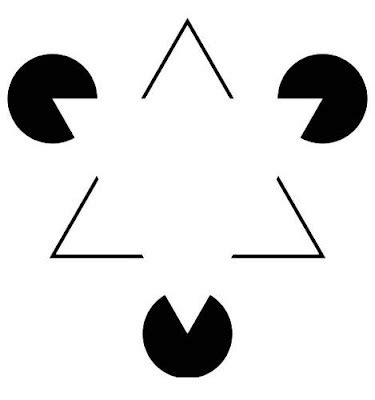

[source](https://miro.medium.com/max/2000/0*NnBMMDYOlNXHJYCw.png)

But in fact there is no white triangle. However, we humans tend to group parts of the images such that we perceive coherent, global shapes. It has been argued that *recurrence* in the neural substrate responsible for visual processing may underlie computations that benefit task performance by making use of these contextual signals ([Roelfsema et al., 2007](https://www.sciencedirect.com/science/article/pii/S0896627307007623); [van Bergen & Kriegeskorte, 2020](https://www.sciencedirect.com/science/article/pii/S0959438820301768)).

Feedforward Neural Networks (FNN) have been widely used to solve object recognition. However, Recurrent Neural Networks (RNN) -- already popular for decades in language processing -- have been recently been introduced into the domain of visual processing to help solve common problems of FNN approaches and to model information that humans seem to use when categorizing objects. They do this by incorporating an abundance of recurrent activity which means that the unit activations are a fuction both of the input and their prior activations. It is however, still unclear whether during object recognition category orthogonal information (such as objects location, orientation or scale) are discarded or used by RNNs as auxillary information. Looking at the image above suggests that these auxillary information can indeed be very important for object categorization. 

The authors of our *Key Paper* try to shed light onto the role of auxiliary information. They do this by training and testing multiple instances of an RNN on an object categorization task while presenting target objects in cluttered environments. To investigate the inner workings of these models and to characterize which information related to auxiliary variables is present, they utilize diagnostic read-outs (*probes* or *diagnostic classifiers*) across layers and time.

###Goals of the workshop

In this workshop, you will first replicate the process of generating the stimuli, followed by instantiating the networks. The core of the workshop is then to replicate some the main findings from the key paper, and to interpret the results.



# Dataset

Let's start with visualizing some of the images contained in the vanilla versions of the [MNIST](https://www.tensorflow.org/datasets/catalog/mnist) and [Fashion-MNIST (FMNIST)](https://github.com/zalandoresearch/fashion-mnist) datasets: Both datasets contain 10 image classes consisting either a single digit number or a clothing item respectivly. 

In [ ]:
# load datasets 
# it is important to note that read_data_sets will download vanilla MNIST when 
# no path specified. Therefore we use the dowloaded datasets from the github page!

mnist = input_data.read_data_sets('/content/svrhm21_RNN_explain/MNIST_data', one_hot=True)
fmnist = input_data.read_data_sets('/content/svrhm21_RNN_explain/fMNIST_data', one_hot=True)

Extracting /content/svrhm21_RNN_explain/MNIST_data/train-images-idx3-ubyte.gz
Extracting /content/svrhm21_RNN_explain/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /content/svrhm21_RNN_explain/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /content/svrhm21_RNN_explain/MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting /content/svrhm21_RNN_explain/fMNIST_data/train-images-idx3-ubyte.gz
Extracting /content/svrhm21_RNN_explain/fMNIST_data/train-labels-idx1-ubyte.gz
Extracting /content/svrhm21_RNN_explain/fMNIST_data/t10k-images-idx3-ubyte.gz
Extracting /content/svrhm21_RNN_explain/fMNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
# define labels
mnist_class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = mnist_class_names + fmnist_class_names

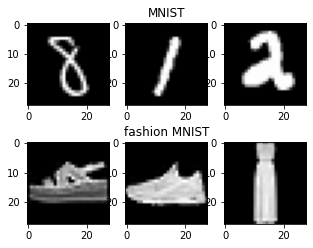

In [ ]:
# initiate plot
fig, axs = plt.subplots(2, 3, figsize=(5, 4))

# count images
mnist_img_count = len(mnist.train.images)
fmnist_img_count = len(fmnist.train.images)

# plot example images
for i in range(3): # columns

    # choose random index and plot mnist example
    sample = random.randint(0, mnist_img_count)
    image = mnist.train.images[sample].reshape(28,28)
    axs[0, i].imshow(image, cmap='gray')

    # choose random index and plot fmnist example
    sample = random.randint(0, fmnist_img_count)
    image = fmnist.train.images[sample].reshape(28,28)
    axs[1, i].imshow(image, cmap='gray')

    if i == 1:
      axs[0, i].set_title('MNIST')
      axs[1, i].set_title('fashion MNIST')

# show plot
plt.show()


## Introduce environment clutter

As you could see the images from both datasets seem far different from our human experience of how we perceive the world. Or would you say your room is clutter free? 

In order to study the effect of recurrent information flow the authors wanted to introduce challenging visual conditions to the target images. To do so they manipulated the target objects in their location (x + y), orientation and scale as well as adding structured clutter i.e. randomly sampled fragments of other objects in the dataset. 

In [ ]:
# create cluttered images
img_num = 12        # number of images to create
img_set = 0         # set used (0 train, 1 val, 2 test)

# create images
inputs_v,_,labels_v,_,_,_,_ = gen_images(img_num, img_set)

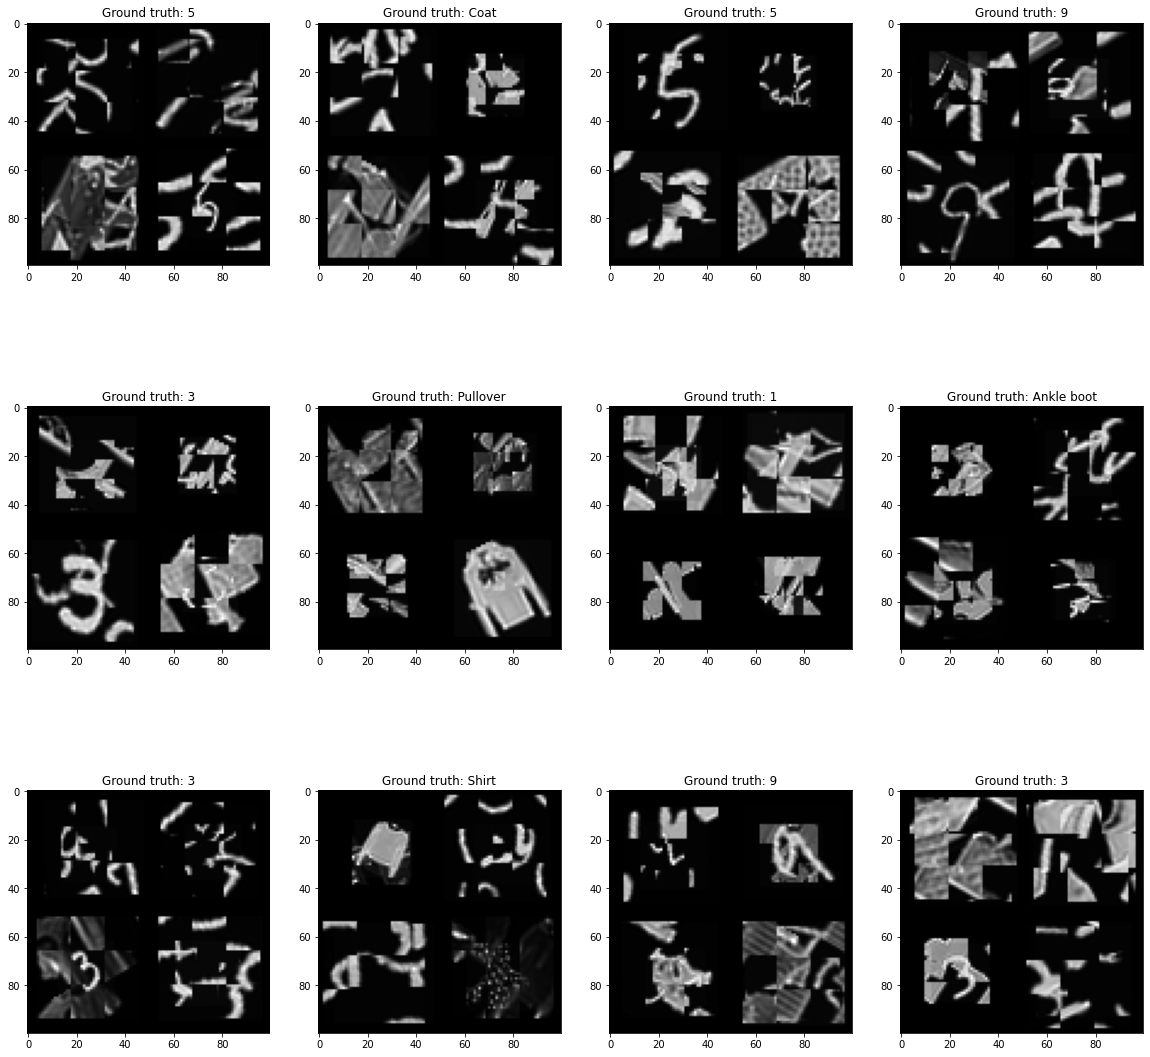

In [ ]:
# initiate plot
fig, axs = plt.subplots(3, 4, figsize=(20, 20))

# plot images
count = 0
for i in range(3):
  for j in range(4):

    # label

    # plot image
    img = inputs_v[count]
    img = np.squeeze(img.reshape(100, 100, 1))
    axs[i, j].imshow(img, cmap='gray')

    # extract ground truth label
    img_idx = np.argwhere(labels_v[count] == 1)[0][0]
    axs[i, j].set_title('Ground truth: ' + class_names[img_idx])

    # increment count
    count = count + 1

# show plot
plt.show()

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 1</b></font>

#@markdown Please answer the following questions:
#@markdown i) How are the cluttered images generated?
#@markdown ii) Could you think of advantage to maintain information about category-orthogonal information fo object recognition? 
Response = "" #@param {type:"string"}

In [ ]:
#@title <font color='red'><b>ToSubmit 1</b></font>

#@markdown Plot four images of the cluttered stimuli next to each other containing the ground truth label '5' (2 plots) and 'Sandal' (2 plots). 

In [ ]:
# you can put your code here

# RNN architecture

The RNN used for training and subsequent analyses consists of two convolutional layers followed by one fully connected (FC) layer, as illustrated in the paper below (Figure 2 in the paper). The architecture contained both lateral and top-down connections and the RNN was unrolled for 4 timesteps. Finally, the activations of the FC layer were concatenated and mapped to the classification output (i.e. `class_names`) using an FC layer.

![Paper Figure 2](img/04_lab_paper_figure2.png)

**Paper Figure 2**

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 2</b></font>

#@markdown How is the recurrent connectivity operationalized and what are the computations being used? 
Response = "" #@param {type:"string"}

## Import network architecture

Here we use the authors' code from [Github](https://github.com/KietzmannLab/svrhm21_RNN_explain.git) to instantiate their RNN implementation which incorporates both lateral and top-down connections. By clicking on the cell you can view their code to understand the implementation details. 

In [ ]:
#@title Defining the RNN class (click to see code)

class RNNet_all_fbr(nn.Module):
    def __init__(self, n_feats=8, ker_size=5,t_steps=3,b_flag=1,g_flag=1,l_flag=1,t_flag=1):
        super(RNNet_all_fbr, self).__init__()
        self.conv1 = nn.Conv2d(1, n_feats, ker_size)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(n_feats, n_feats*2, ker_size)
        self.fc1 = nn.Linear(n_feats*2 * 9 * 9, n_feats*16)
        self.fc2 = nn.Linear(n_feats*16*t_steps, 20)
        self.dropout = nn.Dropout(0.5)
        self.c1xb = nn.ConvTranspose2d(n_feats,1,7,3) # in_channel, out_channel, kernel_size, stride, padding
        self.c2xb = nn.ConvTranspose2d(n_feats*2,1,20,10)
        self.fc1xb = nn.Linear(n_feats*16, 100*100)
        self.c1c1b = nn.Conv2d(n_feats, n_feats, ker_size, 1, 2)
        self.c2c1b = nn.ConvTranspose2d(n_feats*2,n_feats,16,10)
        self.fc1c1b = nn.Linear(n_feats*16, 96*96*n_feats)
        self.c2c2b = nn.Conv2d(n_feats*2, n_feats*2, ker_size, 1, 2)
        self.fc1c2b = nn.Linear(n_feats*16, 28*28*n_feats*2)
        self.fc1fc1b = nn.Linear(n_feats*16, n_feats*16)
        self.c1xg = nn.ConvTranspose2d(n_feats,1,7,3) # in_channel, out_channel, kernel_size, stride, padding
        self.c2xg = nn.ConvTranspose2d(n_feats*2,1,20,10)
        self.fc1xg = nn.Linear(n_feats*16, 100*100)
        self.c1c1g = nn.Conv2d(n_feats, n_feats, ker_size, 1, 2)
        self.c2c1g = nn.ConvTranspose2d(n_feats*2,n_feats,16,10)
        self.fc1c1g = nn.Linear(n_feats*16, 96*96*n_feats)
        self.c2c2g = nn.Conv2d(n_feats*2, n_feats*2, ker_size, 1, 2)
        self.fc1c2g = nn.Linear(n_feats*16, 28*28*n_feats*2)
        self.fc1fc1g = nn.Linear(n_feats*16, n_feats*16)
        self.n_feats = n_feats
        self.t_steps = t_steps
        self.b_flag = b_flag
        self.g_flag = g_flag
        self.l_flag = l_flag
        self.t_flag = t_flag
    def forward(self, x):
        actvs = {}
        actvs[0] = {}
        actvs[1] = {}
        actvs[2] = {}
        actvs[3] = {}
        fb_acts = {}
        fb_acts[0] = {}
        fb_acts[1] = {}
        fb_acts[2] = {}
        fb_acts[3] = {}
        fb_acts_comb = {}
        fb_acts_comb[0] = {}
        fb_acts_comb[1] = {}
        fb_acts_comb[2] = {}
        fb_acts_comb[3] = {}
        for i in np.arange(2):
            fb_acts[0][i] = {}
            fb_acts[1][i] = {}
            fb_acts[2][i] = {}
            fb_acts[3][i] = {}
            fb_acts_comb[0][i] = {}
            fb_acts_comb[1][i] = {}
            fb_acts_comb[2][i] = {}
            fb_acts_comb[3][i] = {}
            for j in np.arange(3):
                fb_acts[0][i][j] = {}
                fb_acts[1][i][j] = {}
                if j > 0:
                    fb_acts[2][i][j-1] = {}
                    if j > 1:
                        fb_acts[3][i][j-2] = {}
        actvs[0][0] = F.relu(x) - F.relu(x-1)
        c1 = F.relu(self.conv1(actvs[0][0]))
        actvs[1][0] = self.pool(c1)
        c2 = F.relu(self.conv2(actvs[1][0]))
        actvs[2][0] = self.pool(c2)
        actvs[3][0] = F.relu(self.fc1(actvs[2][0].view(-1, self.n_feats*2 * 9 * 9)))
        actvs[4] = actvs[3][0]
        if self.t_steps > 0:
            for t in np.arange(self.t_steps-1):
                fb_acts[0][0][0][t] = self.t_flag*self.c1xb(actvs[1][t])
                fb_acts[0][0][1][t] = self.t_flag*self.c2xb(actvs[2][t])
                fb_acts[0][0][2][t] = self.t_flag*(self.fc1xb(actvs[3][t])).view(-1,1,100,100)
                fb_acts_comb[0][0][t] = fb_acts[0][0][0][t] + fb_acts[0][0][1][t] + fb_acts[0][0][2][t]
                fb_acts[0][1][0][t] = self.t_flag*self.c1xg(actvs[1][t])
                fb_acts[0][1][1][t] = self.t_flag*self.c2xg(actvs[2][t])
                fb_acts[0][1][2][t] = self.t_flag*(self.fc1xg(actvs[3][t])).view(-1,1,100,100)
                fb_acts_comb[0][1][t] = fb_acts[0][1][0][t] + fb_acts[0][1][1][t] + fb_acts[0][1][2][t]
                dumh000 = (x + self.b_flag*(self.t_flag*(self.c1xb(actvs[1][t])+self.c2xb(actvs[2][t])+(self.fc1xb(actvs[3][t])).view(-1,1,100,100)))) * (1.+self.g_flag*self.t_flag*(self.c1xg(actvs[1][t])+self.c2xg(actvs[2][t])+(self.fc1xg(actvs[3][t])).view(-1,1,100,100)))
                actvs[0][t+1] = (F.relu(dumh000) - F.relu(dumh000-1))
                fb_acts[1][0][0][t] = self.l_flag*self.c1c1b(c1)
                fb_acts[1][0][1][t] = self.t_flag*self.c2c1b(actvs[2][t])
                fb_acts[1][0][2][t] = self.t_flag*(self.fc1c1b(actvs[3][t])).view(-1,self.n_feats,96,96)
                fb_acts_comb[1][0][t] = fb_acts[1][0][0][t] + fb_acts[1][0][1][t] + fb_acts[1][0][2][t]
                fb_acts[1][1][0][t] = self.l_flag*self.c1c1g(c1)
                fb_acts[1][1][1][t] = self.t_flag*self.c2c1g(actvs[2][t])
                fb_acts[1][1][2][t] = self.t_flag*(self.fc1c1g(actvs[3][t])).view(-1,self.n_feats,96,96)
                fb_acts_comb[1][1][t] = fb_acts[1][1][0][t] + fb_acts[1][1][1][t] + fb_acts[1][1][2][t]
                c1 = F.relu(self.conv1(actvs[0][t+1])+self.b_flag*(self.l_flag*self.c1c1b(c1)+self.t_flag*(self.c2c1b(actvs[2][t])+(self.fc1c1b(actvs[3][t])).view(-1,self.n_feats,96,96)))) * (1.+self.g_flag*(self.l_flag*self.c1c1g(c1)+self.t_flag*(self.c2c1g(actvs[2][t])+(self.fc1c1g(actvs[3][t])).view(-1,self.n_feats,96,96))))
                actvs[1][t+1] = self.pool(c1)
                fb_acts[2][0][0][t] = self.l_flag*self.c2c2b(c2)
                fb_acts[2][0][1][t] = self.t_flag*(self.fc1c2b(actvs[3][t])).view(-1,self.n_feats*2,28,28)
                fb_acts_comb[2][0][t] = fb_acts[2][0][0][t] + fb_acts[2][0][1][t]
                fb_acts[2][1][0][t] = self.l_flag*self.c2c2g(c2)
                fb_acts[2][1][1][t] = self.t_flag*(self.fc1c2g(actvs[3][t])).view(-1,self.n_feats*2,28,28)
                fb_acts_comb[2][1][t] = fb_acts[2][1][0][t] + fb_acts[2][1][1][t]
                c2 = F.relu(self.conv2(actvs[1][t+1])+self.b_flag*(self.l_flag*self.c2c2b(c2)+self.t_flag*(self.fc1c2b(actvs[3][t])).view(-1,self.n_feats*2,28,28))) * (1.+self.g_flag*(self.l_flag*self.c2c2g(c2)+self.t_flag*(self.fc1c2g(actvs[3][t])).view(-1,self.n_feats*2,28,28)))
                actvs[2][t+1] = self.pool(c2)
                fb_acts[3][0][0][t] = self.l_flag*self.fc1fc1b(actvs[3][t])
                fb_acts[3][1][0][t] = self.l_flag*self.fc1fc1g(actvs[3][t])
                fb_acts_comb[3][0][t] = fb_acts[3][0][0][t]
                fb_acts_comb[3][1][t] = fb_acts[3][1][0][t]
                actvs[3][t+1] = F.relu(self.fc1(actvs[2][t+1].view(-1, self.n_feats*2 * 9 * 9))+self.b_flag*self.l_flag*self.fc1fc1b(actvs[3][t])) * (1.+self.g_flag*self.l_flag*self.fc1fc1g(actvs[3][t]))
                actvs[4] = torch.cat((actvs[4],actvs[3][t+1]),1)
        actvs[5] = torch.log(torch.clamp(F.softmax(self.fc2(actvs[4]),dim=1),1e-10,1.0))
        return actvs, fb_acts, fb_acts_comb

Initialize the RNN using the hyperparameters used by the authors. 

In [ ]:
# Hyperparameters
n_feats = 8 # in Conv layer 1
ker_size = 5 # in Conv layer 1
b_h = 0 # bias modulation flag
g_h = 1 # gain modulation flag
l_h = 1 # lateral interactions flag
t_h = 1 # top-down interactions flag

net_num = 1

t_steps = 4

net_save_str = 'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num)

# initiaize RNN
#net = RNNet_all(n_feats,ker_size,t_steps,b_h,g_h,l_h,t_h)
net = RNNet_all_fbr(n_feats,ker_size,t_steps,b_h,g_h)
net = net.float()

## Download and load pretrained weights

On the projects [OSF](https://osf.io/pf4u5/) page the authors published pretrained weights for the RNN they used. The RNN was trained for 20-way classification using a cross-entropy loss. They used the Adam optimizer for training, with a batch size of 32, and learning rate of $10^{−4}$. The network was trained for 300.000 iterations. 

In [ ]:
# get weights from OSF
# first set of weights
!wget -c https://osf.io/wxmkv/download/ -O rnn_bglt_0111_t_4_num_1.pth
# second set of weights
!wget -c https://osf.io/98tgk/download -O rnn_bglt_1011_t_4_num_1.pth

--2022-06-14 11:11:45--  https://osf.io/wxmkv/download/
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/pf4u5/providers/osfstorage/6188e956dde25b0240fa44e5?action=download&direct&version=1 [following]
--2022-06-14 11:11:45--  https://files.de-1.osf.io/v1/resources/pf4u5/providers/osfstorage/6188e956dde25b0240fa44e5?action=download&direct&version=1
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-06-14 11:11:46--  https://osf.io/98tgk/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FO

In [ ]:
# Load weights into the initialized RNN model
net.load_state_dict(torch.load(net_save_str +'.pth',map_location=torch.device('cpu')))
net.eval()

RNNet_all_fbr(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=512, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (c1xb): ConvTranspose2d(8, 1, kernel_size=(7, 7), stride=(3, 3))
  (c2xb): ConvTranspose2d(16, 1, kernel_size=(20, 20), stride=(10, 10))
  (fc1xb): Linear(in_features=128, out_features=10000, bias=True)
  (c1c1b): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c2c1b): ConvTranspose2d(16, 8, kernel_size=(16, 16), stride=(10, 10))
  (fc1c1b): Linear(in_features=128, out_features=73728, bias=True)
  (c2c2b): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1c2b): Linear(in_features=128, out_features=12544, bias=True)
  (fc1fc1b): Linear(in_features=128, out_features=

In [ ]:
#@title <font color='red'><b>ToSubmit 2</b></font>

#@markdown Can you infer the number of lateral and recurrent connections? Write down the number as well as the associated layer names for the whole model (e.g. lateral: number of connections: ..., names: e.g. fc1, fc2, ...)? Hint: look at the picture depicting the model plotted at the beginning of this section.

# Results

In this part of the tutorial, we will follow the authors in how they analyzed the networks' activations to shed light on whether or not auxiliary variables get extracted and represented in the RNN or if they are suppressed. This will help us to understand the information flow in the network, as well as the network performance.

First, the authors study the presence and the flow of category-orthogonal information flow in the RNN activation patterns across layers and timesteps.

Second, they looked how the information flow of category-orthogonal guides subsequent network performance.

## Studying category-orthogonal information flow

Again we create a subset of cluttered images. This time we are using the validation set and we pass them to the pre-trained network for 4 timesteps. 

In [ ]:
# create cluttered images using the authors helper function gen_images
inputs_v,inputs_v_c,labels_v,_,_,_,_ = gen_images(5,1)
inputs_v = torch.from_numpy(inputs_v).float()
inputs_v_c = torch.from_numpy(inputs_v_c).float()

# pass it to the network
outputs,_,out_fbr_comb = net(inputs_v.float())

Now, let's have a look at the Input, and the effect of the recurrent information flow for all timesteps:

True label: 4 ; Predicted label: 4
True label: Dress ; Predicted label: Coat
True label: 7 ; Predicted label: Sneaker
True label: Trouser ; Predicted label: Trouser


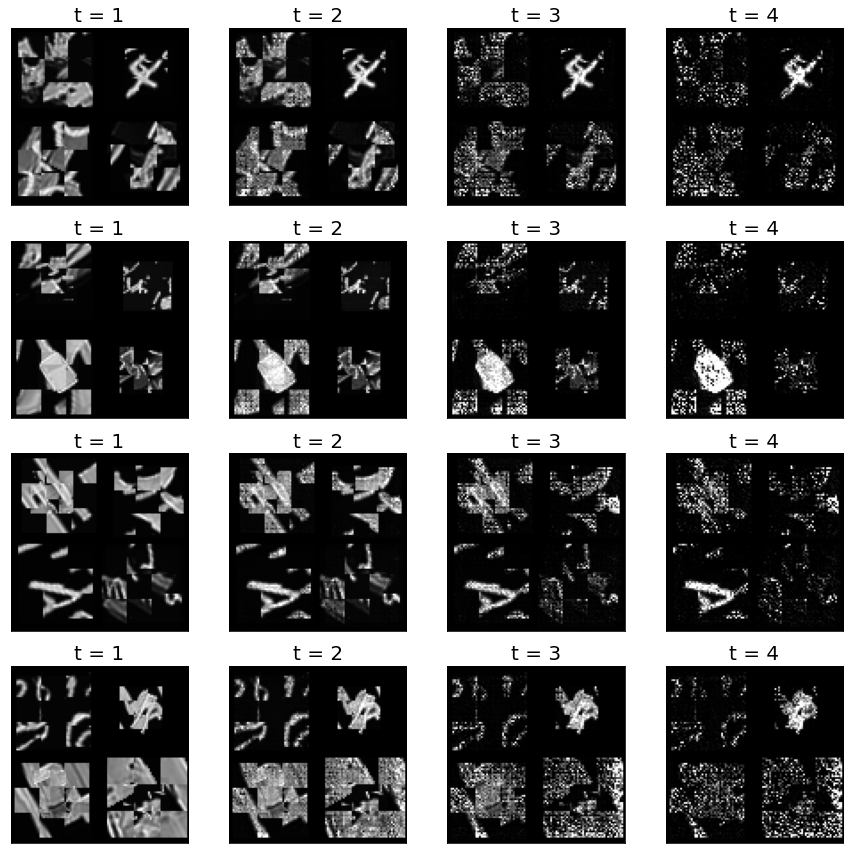

In [ ]:
plt.figure(figsize=(15,15))
for i in np.arange(4):
    print('True label:', class_names[np.where(labels_v[i,:])[0][0]], '; Predicted label:', class_names[np.where(outputs[5][i].detach().numpy()==np.max(outputs[5][i].detach().numpy()))[0][0]])
    for j in np.arange(t_steps):
        plt.subplot(4,t_steps,(i)*t_steps+j+1)
        plt.imshow(outputs[0][j][i,0,:,:].detach().numpy(),cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title('t = '+str(j+1),fontsize=20)

**Paper Figure 3 (B)**

In [ ]:
#@title <font color='red'><b>ToSubmit 3</b></font>

#@markdown Briefly describe how the network maintains object and orthogonal information over time and how this relates to the lateral/recurrent connections.

Now let's have a look how information is maintained. More particularly, we will look at both the auxiliary variables as well as the category information. 

Output category accuracies:  0.81226
Auxiliary variable avg. decoding through time:  [0.65223333 0.730225   0.82524583 0.84927083]
Auxiliary variable avg. decoding through layer depth:  [0.70119167 0.7465125  0.81060833 0.7986625 ]


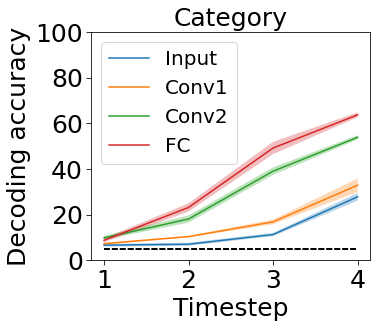

In [ ]:
dec_acc1 = np.zeros([4,t_steps,5,2,5])
out_acc1 = np.zeros([5,2])
fbr_accs_all_comb1 = np.zeros([4,t_steps-1,2,5,5])
for net_num1 in np.arange(5):
    dec_accs_str = 'svrhm21_RNN_explain/analyses/'+'dec_acc'+'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num1+1)+'.npy'
    with open(dec_accs_str, 'rb') as f:
        dec_acc = np.load(f)
        out_acc = np.load(f)
        fbr_accs_all_comb = np.load(f)
    dec_acc1[:,:,0,:,net_num1] = np.mean(dec_acc[:,:,0,:,:],3)
    dec_acc1[:,:,1,:,net_num1] = np.mean(np.mean(dec_acc[:,:,1:3,:,:],4),2)
    dec_acc1[:,:,2:,:,net_num1] = np.mean(dec_acc[:,:,3:,:,:],4)
    out_acc1[net_num1,:] = np.mean(out_acc,1)
    fbr_accs_all_comb1[:,:,:,0,net_num1] = np.mean(fbr_accs_all_comb[:,:,:,0,:],3)
    fbr_accs_all_comb1[:,:,:,1,net_num1] = np.mean(np.mean(fbr_accs_all_comb[:,:,:,1:3,:],4),3)
    fbr_accs_all_comb1[:,:,:,2:,net_num1] = np.mean(fbr_accs_all_comb[:,:,:,3:,:],4)

var_names = ['Category']
plt.figure(figsize=(5,4.2))
for i in np.arange(1):
    plt.subplot(1,1,i+1)
    for j in np.arange(4):
        plt.plot(np.arange(t_steps)+1,np.transpose(np.mean(dec_acc1[j,:,i,0,:],1))*100.)
        y = np.transpose(dec_acc1[j,:,i,0,:])*100.
        ci = 1.96 * np.std(y,0)/np.sqrt(5)
        plt.fill_between(np.arange(t_steps)+1, (np.mean(y,0)-ci), (np.mean(y,0)+ci), alpha=.3)
    if i == 0:
        plt.plot(np.arange(t_steps)+1,0*np.transpose(np.mean(dec_acc1[0:4,:,i,0,:],2))+5,'k--')
    plt.xticks(np.arange(t_steps)+1,fontsize=25)
    plt.yticks(fontsize=25)
    if i == 0:
        plt.legend(['Input','Conv1','Conv2','FC'],fontsize=20)
        plt.ylim([0,100])
        plt.ylabel('Decoding accuracy',fontsize=25)
    else:
        plt.ylim([50,100])
    plt.tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
    plt.title(var_names[i],fontsize=25)
    plt.xlabel('Timestep',fontsize=25)
    
print('Output category accuracies: ',np.mean(out_acc1,0)[0])
print('Auxiliary variable avg. decoding through time: ',np.mean(np.mean(np.mean(dec_acc1[:,:,1:4,0,:],3),2),0))
print('Auxiliary variable avg. decoding through layer depth: ',np.mean(np.mean(np.mean(dec_acc1[:,:,1:4,0,:],3),2),1))

In [ ]:
#@title <font color='red'><b>ToSubmit 4</b></font>

#@markdown Please plot the decoding accuracy for the auxiliary variables (i.e., location, scale, orientation) as well, similar to the plot above. 

In [ ]:
var_names = ['Location','Scale','Orientation']

# please write the code below
# plt.figure(figsize=(...)

# for i in np.arange(...):
#     plt.subplot(...)

# ...


############################   

**Paper Figure 3 (A)**

In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 3</b></font>

#@markdown How would you interpret the plots above? How is information about auxiliary variables contributing to the decoding accuracy?
Response = "" #@param {type:"string"}

## Perturbation analysis

Now next you ask if the succesful decoding of auxiliary variables from recurrent information flow also functionally contributes. For this, a permutation test was conducted, in which the feedback to a given layer and timepoint was exchanged with feedback extracted from another, systematically perturbed, image from the dataset (see figure below). (Note that, methodlogically, this is similar to what we call *interventions* in the AI literature on causality and probing/diagnostic classifiers (e.g., Guilianelli et al., 2018).)

![Paper Figure 4](img/04_lab_paper_figure4.png)

**Paper Figure 4**

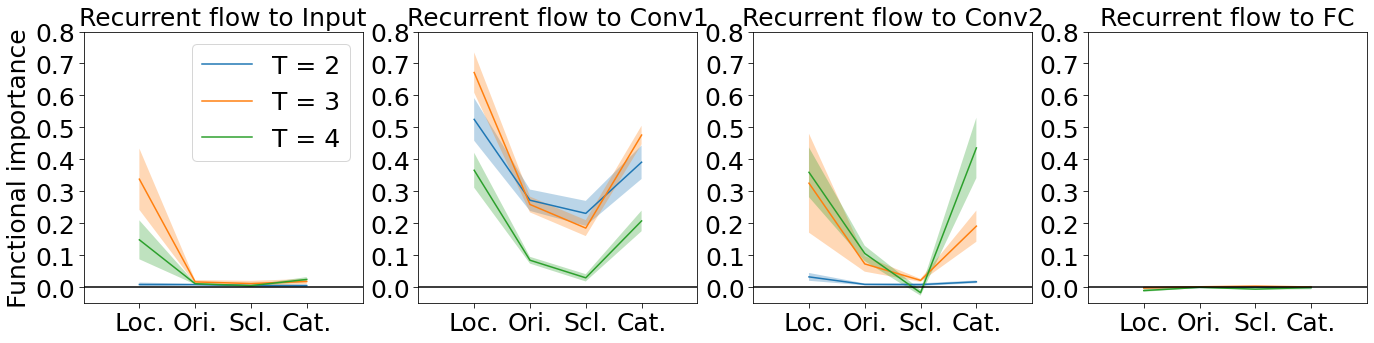

In [ ]:
org_accs_h = np.zeros([5,1])
pert_accs_h = np.zeros([5,4,2,4,3])
pert_accs_cat_sep = np.zeros([5,2,2,4,3])
for net_num1 in np.arange(5):
    out_str = 'svrhm21_RNN_explain/analyses/'+'fb_perturb-'+'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num1+1)+'.npy'
    with open(out_str, 'rb') as f:
        original_accuracy = np.load(f)
        perturbed_accuracies = np.load(f)
    org_accs_h[net_num1] = np.mean(original_accuracy)*100
    pert_accs_h[net_num1,0,:,:,:] = np.mean(np.mean(perturbed_accuracies[0:2,:,:,:,:],4),0)*100
    pert_accs_h[net_num1,1:3,:,:,:] = np.mean(perturbed_accuracies[2:4,:,:,:,:],4)*100
    pert_accs_h[net_num1,3,:,:,:] = np.mean(np.mean(perturbed_accuracies[4:6,:,:,:,:],4),0)*100
    pert_accs_cat_sep[net_num1,0,:,:,:] = np.mean(np.mean(perturbed_accuracies[4:5,:,:,:,:],4),0)*100
    pert_accs_cat_sep[net_num1,1,:,:,:] = np.mean(np.mean(perturbed_accuracies[5:6,:,:,:,:],4),0)*100

pert_names = ['Location','Orientation','Scale','Category (avg)']
lay_names = ['Input','Conv1','Conv2','FC']


perturbed_relative = np.zeros([4,4,3])
pert_rel_se = np.zeros([4,4,3])
for lay in np.arange(4):
    for pert in np.arange(4):
        for th in np.arange(3):
            perturbed_relative[pert,lay,th] = np.mean((pert_accs_h[:,pert,1,lay,th] - pert_accs_h[:,pert,0,lay,th])/org_accs_h)
            pert_rel_se[pert,lay,th] = 1.96*np.std((pert_accs_h[:,pert,1,lay,th] - pert_accs_h[:,pert,0,lay,th])/org_accs_h)/np.sqrt(5)
plt.figure(figsize=(23,5))
pert_names = ['Loc.','Ori.','Scl.','Cat.']
for lay in np.arange(4):
    plt.subplot(1,4,lay+1)
    for th in np.arange(3):
        plt.plot(np.arange(4)+1,perturbed_relative[:,lay,th])
        plt.fill_between(np.arange(4)+1, (perturbed_relative[:,lay,th]-pert_rel_se[:,lay,th]), (perturbed_relative[:,lay,th]+pert_rel_se[:,lay,th]), alpha=.3)
    plt.plot(np.arange(6),0*np.arange(6),'k-')
    plt.xticks(np.arange(4)+1,pert_names,fontsize=25)
    plt.yticks(fontsize=25)
    plt.ylim([-.05,0.8])
    plt.xlim([0,5])
    plt.title('Recurrent flow to '+lay_names[lay],fontsize=25)
    if lay == 0:
        plt.legend(['T = 2','T = 3','T = 4'],fontsize=25)
        plt.ylabel('Functional importance',fontsize=25)
    plt.tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)

**Paper Figure 4 (D)**

In [ ]:
#@title <font color='red'><b>ToSubmit 5</b></font>

#@markdown Please do the following: i) describe what you see in the plots, ii) what conclusions can you draw in terms of the variables with respect to network performance and iii) critically think about this and give a possible expanation for the observed results. 

# Future work


In [ ]:
#@title <font color='cornflowerblue'><b>ToThink 4</b></font>

#@markdown What would you like to explore further? Give two suggestions for future research in studying recurrent information flow in object recognition inspired by what you have learned in this workshop.

In [ ]:
#@title <font color='red'><b>ToSubmit 6</b></font>

#@markdown Max 1/2 page where you explain your two ideas.

# Final remarks
This is the end of the tutorial. By know you should have a better idea how the recurrent infromation flow can improve the categorization performance and that category-orthogonal information is extracted rather than filterd out. 

## Suggestions miniproject

Possible topics research project:
- How would the task be solved if there is another digit (MNIST) or piece of colthing (fMNIST) that’s not relevant for the categorization
- What is the effect when the target object is scattered such that the global shape is preserved, but the local texture is permutated?
- Could you gain more insights in learning the contribution of the pixel space in the object recognition using interpretable AI, such as LRP?
- Would there be other category-orthogonal features that could be explored?
- How is information flow different for multiplicative and additive recurrent interactions?